## Libreria y conexión con ETABS

In [1]:
import pandas as pd
import numpy as np
import comtypes.client
import sys
import matplotlib.pyplot as plt
import os
import math
import openpyxl

def connect_to_existing_etabs():
    
        helper = comtypes.client.CreateObject('ETABSv1.Helper');
        helper = helper.QueryInterface(comtypes.gen.ETABSv1.cHelper);

        try:
            myETABSObject = helper.GetObject("CSI.ETABS.API.ETABSObject");
            print("Conectado exitosamente")
        except (OSError,comtypes.COMError):
            print("Ha fallado.")
            sys.exit(-1);

        SapModel = myETABSObject.SapModel
        return SapModel,myETABSObject,helper;

SapModel, myETABSObject, helper = connect_to_existing_etabs()

# Ton_m_C = 12
tonf_m_C = 12
ret = SapModel.SetPresentUnits(tonf_m_C)

Conectado exitosamente


## Creación del caso no lineal estático por gravedad

In [5]:
ret = SapModel.LoadCases.StaticNonlinear.SetCase("GRAV")

MyLoadType = ["Load", "Load"]
MyLoadName = ["Dead", "Live"]
MySF = [1,0.25]
ret = SapModel.LoadCases.StaticNonlinear.SetLoads("GRAV",
                                                2,
                                                MyLoadType,
                                                MyLoadName,
                                                MySF)

ret

[('Load', 'Load'), ('Dead', 'Live'), (1.0, 0.25), 0]

## Creación del análisis no lineal de carga lateral

In [11]:
ret = SapModel.LoadCases.StaticNonlinear.SetCase("ANLE XX")

MyLoadType = {"Mode"}
MyLoadName = {"1"}
MySF = [1]
ret = SapModel.LoadCases.StaticNonlinear.SetLoads("ANLE XX",
                                                1,
                                                MyLoadType,
                                                MyLoadName,
                                                MySF)

ret

[('Mode',), ('1',), (1.0,), 0]

## Añadiendo opciones del análisis no lineal estático

In [13]:
#AGREGAR CASO INICIAL
ret = SapModel.LoadCases.StaticNonlinear.SetInitialCase('ANLE XX','GRAV')


# PARÁMETROS DE APLICACIÓN DE CARGAS
ret = SapModel.LoadCases.StaticNonlinear.SetLoadApplication('ANLE XX',     # Nombre de la carga a modificar
                                                             2,            # Tipo de control (fuerza,displazamiento)
                                                             2,            # Tipo de Control de desplazamiento
                                                             0.2,          # Desplazamiento de control en metros
                                                             1,            # Monitor (1=en un punto objetivo, 2=generalizado)
                                                             1,            # Dirección de análisis, 1=U1, 2=U2 (Aplica si el superior es 1)
                                                             '90',        # Unique Name del punto a evaluar
                                                             '')           # Aplica cuando monitor es 2


# RESULTADOS GUARDADOS

ret = SapModel.LoadCases.StaticNonlinear.SetResultsSaved('ANLE XX',       # Nombre de la carga a modificar
                                                   True,                  # True = Multiple states, False=Final state only    
                                                   200,                   # Número mínimo de resultados guardados                                          
                                                   400,                   # Número máximo de resultados guardados                                                        
                                                   True)                  # True = Solo guardar resultados positivos


# PARÁMETROS DE SOLUCIÓN DE CONTROL
ret = SapModel.LoadCases.StaticNonlinear.SetSolControlParameters('ANLE XX',  # Nombre de la carga a modificar
                                                                  400,       # Número máximo de steps
                                                                  200,       # Número máximo de soluciones null (Sin respuesta)
                                                                  15,        # Número máximo de iteraciones constantes
                                                                  50,        # Iteraciones Newton-Raphson
                                                                  0.00005,   # Tolerancia de Convergencia
                                                                  True,      # True = Utilizar EventStepping
                                                                  0.02,      # Tolerancia al error 
                                                                  10,        # No hay en esta versión
                                                                  0.2,       # No hay en esta versión
                                                                  1.7)       # No hay en esta versión


ret

0

## Obtención de la curva de capacidad

In [2]:
#deselect all cases and combos
ret = SapModel.Results.Setup.DeselectAllCasesAndCombosForOutput()

#set case selected for output
ret = SapModel.Results.Setup.SetCaseSelectedForOutput("ANLE XX")

ret=SapModel.DatabaseTables.SetOutputOptionsForDisplay(False,0,0,0,True,0,0,False,0,0,2,2,2,2,1)
ret

0

In [6]:
name_table="Base Reactions"
#name_table = "Modal Participating Mass Ratios"
table = SapModel.DatabaseTables.GetTableForDisplayArray(name_table ,GroupName="")    
cols=table[2]
noOfRows=table[3]
vals=np.array_split(table[4],noOfRows)
df= pd.DataFrame(vals)
df.columns=cols
df

,OutputCase,CaseType,StepType,StepNumber,StepLabel,FX,FY,FZ,MX,MY,MZ,X,Y,Z
0,ANLE XX,NonStatic,Step By Step,0,None,0,0,815.749,4078.7448,-4282.682,0,0,0,0
1,ANLE XX,NonStatic,Step By Step,1,None,-13.1145,-1.089E-05,815.749,4078.7449,-4427.4151,65.5751,0,0,0
2,ANLE XX,NonStatic,Step By Step,2,None,-26.2292,-2.179E-05,815.749,4078.745,-4572.1499,131.1509,0,0,0
3,ANLE XX,NonStatic,Step By Step,3,None,-39.3451,-3.268E-05,815.749,4078.7452,-4716.8972,196.7324,0,0,0
4,ANLE XX,NonStatic,Step By Step,4,None,-52.4712,-4.358E-05,815.749,4078.7453,-4861.7576,262.3652,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,ANLE XX,NonStatic,Step By Step,198,None,-686.8897,-0.0006,815.749,4078.7515,-11863.2473,3434.572,0,0,0
199,ANLE XX,NonStatic,Step By Step,199,None,-686.882,-0.0006,815.749,4078.7515,-11863.1622,3434.5335,0,0,0
200,ANLE XX,NonStatic,Step By Step,200,None,-686.8687,-0.0006,815.749,4078.7515,-11863.0152,3434.4669,0,0,0
201,RX,Combination,Max,None,None,862.8903,0.0008,0,0.0064,9496.4154,4602.0225,0,0,0


In [16]:
# Filtrar los registros donde 'OutputCase' es igual a 'SX'
df = df[df['OutputCase'] == 'ANLE XX']


# Obtener solo la columna 7 (en Python, las columnas se indexan desde 0)
cortantex = df.iloc[:, 5]  # Index 6 corresponde a la columna 7

# Convertir la columna en una lista numérica
cortantex = cortantex.tolist()

# Agregar el valor 0 al final de la lista
#cortantex.append('0')

# Convertir todos los elementos a números (incluso el '0' como cadena)
cortantex = [float(item) for item in cortantex]

# Obtén el último valor de la lista
ultimo_valor = cortantex[-1]

# Verifica si el último valor es menor que 1
if ultimo_valor < 1:
    # Multiplica por -1 todos los valores de la lista usando una comprensión de lista
    cortantex = [-x for x in cortantex]

# Ahora, desplazx contiene la columna 7 como una lista numérica con el valor 0 al final
print(cortantex)
len(cortantex)

[-0.0, 13.1145, 26.2292, 39.3451, 52.4712, 65.6141, 78.7759, 91.919, 104.9902, 117.829, 130.2961, 142.4101, 153.8789, 165.0524, 175.9338, 186.3513, 196.4978, 206.5437, 216.4518, 226.0844, 235.4085, 244.6721, 253.8596, 262.922, 271.8805, 280.77, 289.5032, 298.0977, 306.5245, 314.8681, 323.1117, 331.2958, 339.4626, 347.6825, 355.8852, 364.0891, 372.2574, 380.3478, 388.3821, 396.3611, 404.3264, 412.2782, 420.2209, 428.1703, 436.0932, 443.9887, 451.8693, 459.508, 466.8994, 474.265, 481.5686, 488.8367, 496.0462, 502.9714, 509.572, 516.1149, 522.6456, 529.1693, 535.5981, 541.7231, 547.8285, 553.9265, 560.0746, 566.2194, 572.3265, 578.4068, 584.4796, 590.4321, 595.9163, 600.6962, 605.1583, 609.4406, 613.5547, 617.6659, 621.68, 625.6814, 629.7273, 633.639, 637.5849, 641.4022, 645.106, 648.7029, 652.3329, 655.9563, 659.3232, 662.3869, 665.2466, 668.004, 670.7258, 673.265, 675.7502, 678.2061, 680.5338, 682.956, 685.3774, 687.6941, 689.9459, 692.1765, 694.2285, 696.1215, 697.8023, 699.3608, 700.7

201

In [17]:
# Inicializamos una lista vacía para almacenar los valores
valores = []

# Definimos el paso (0.001) y el valor máximo (0.2)
paso = 0.001
valor_maximo = 0.2+paso

# Usamos un bucle while para generar los valores y agregarlos a la lista
valor_actual = 0.0
while valor_actual <= valor_maximo:
    valores.append(round(valor_actual, 3))  # Redondeamos a 3 decimales y agregamos a la lista
    valor_actual += paso

# Imprimimos la lista resultante
print(valores)
len(valores)


[0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029, 0.03, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039, 0.04, 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049, 0.05, 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059, 0.06, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069, 0.07, 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079, 0.08, 0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089, 0.09, 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1, 0.101, 0.102, 0.103, 0.104, 0.105, 0.106, 0.107, 0.108, 0.109, 0.11, 0.111, 0.112, 0.113, 0.114, 0.115, 0.116, 0.117, 0.118, 0.119, 0.12, 0.121, 0.122, 0.123, 0.124, 0.125, 0.126, 0.127, 0.128, 0.129, 0.13, 0.131, 0.132, 0.133, 0.134, 0.135, 0.136, 0.137, 0.138, 0.139, 0.14, 0.141, 0.142, 0.143, 0.144, 0

201

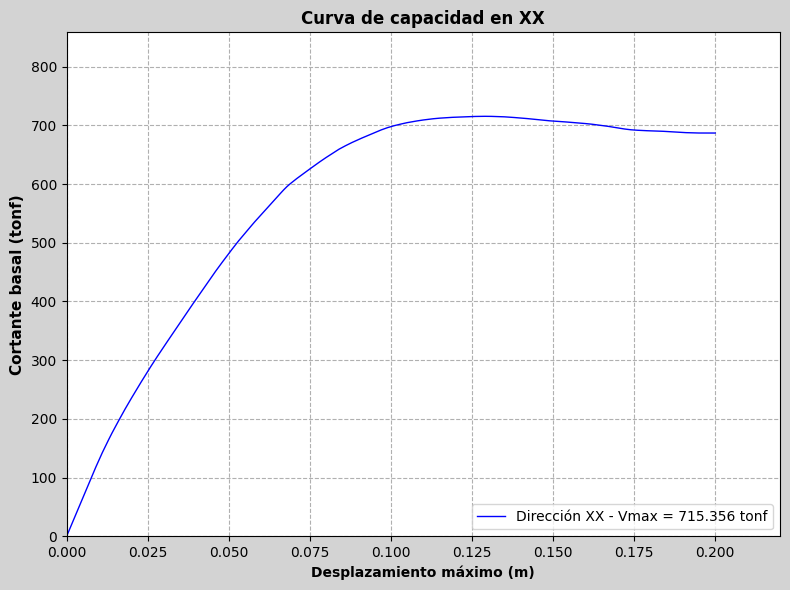

In [19]:
# Valor máximo de desplazx
max_cortantex = round(max(cortantex), 3)

# Crear el gráfico de dispersión con línea de conexión
#plt.figure(figsize=(8, 6))  # Tamaño del gráfico
plt.figure(figsize=(8, 6), facecolor='lightgray')  # Tamaño del gráfico y color de fondo gris
#plt.scatter(desplazx, niveles, label='', marker='o', color='b', s=15)  # Puntos de dispersión
plt.plot(valores,cortantex, label=f'Dirección XX - Vmax = {max_cortantex} tonf', color='b', linewidth=1)  # Línea de conexión
plt.xlabel('Desplazamiento máximo (m)', fontsize=10, fontweight='bold')  # Etiqueta del eje X
plt.ylabel('Cortante basal (tonf)', fontsize=11, fontweight='bold')  # Etiqueta del eje Y
plt.title('Curva de capacidad en XX', fontsize=12, fontweight='bold')  # Título del gráfico

# Leyenda en la parte inferior derecha
plt.legend(loc='lower right')

# Configuraciones adicionales para hacerlo más formal
plt.grid(True, linestyle='--')  # Cuadrícula con líneas punteadas
plt.tick_params(axis='both', which='major', labelsize=10)  # Tamaño de las etiquetas de los ejes
plt.xticks(rotation=0)  # Rotar etiquetas del eje X si es necesario
plt.xlim(0, max(valores)*1.1)  # Establecer límites del eje X desde 0 hasta el valor máximo de desplazx
plt.ylim(0, max(cortantex)*1.2)  # Establecer límites del eje Y desde 0 hasta el valor máximo de niveles
plt.tight_layout()  # Ajustar el diseño

# Guardar el gráfico en un archivo (opcional)
plt.savefig('curvacapacidadxx.png', dpi=300)

# Mostrar el gráfico
plt.show()